# 03. Entrenamiento - Evaluación

## Librerías importadas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, cross_validate, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler

from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
import matplotlib as mpl
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import  mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import xgboost
import warnings
import pickle
from sklearn.feature_selection import SelectKBest, f_regression, r_regression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from sklearn.neural_network import MLPRegressor
import json
import yaml
import tensorflow as tf
from tensorflow import keras
import os

### Carga de datos de entrenamiento

In [2]:
df= pd.read_csv("../data/processed/data_processed.csv")

In [3]:
df.head(3)

,title,vintage,winery,style,variety,denominacion,price,designation,aging_1,region,description,points
0,CVNE 2016 Pagos de Viña Real (Rioja),2016,CVNE,Red wine,Tempranillo,Rioja,125.0,Pagos de Viña Real,No Aplica,Rioja,"Ripe, earthy berry aromas include spice notes ...",97
1,CVNE 2011 Imperial Gran Reserva (Rioja),2011,CVNE,Red wine,Tempranillo,Rioja,88.0,Imperial Gran Reserva,Gran Reserva,Rioja,This is a fabulous gran reserva from a very go...,97
2,Torres 2011 Reserva Real Red (Penedès),2011,Torres,Red wine,Bordeaux-style Red Blend,Penedés,225.0,Reserva Real,Reserva,Penedès,"Spicy berry aromas are herbal, classy, elevate...",96


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116 entries, 0 to 3115
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3116 non-null   object 
 1   vintage       3116 non-null   int64  
 2   winery        3116 non-null   object 
 3   style         3116 non-null   object 
 4   variety       3116 non-null   object 
 5   denominacion  3116 non-null   object 
 6   price         3116 non-null   float64
 7   designation   2553 non-null   object 
 8   aging_1       3116 non-null   object 
 9   region        3116 non-null   object 
 10  description   3116 non-null   object 
 11  points        3116 non-null   int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 292.3+ KB


In [5]:
df.describe(include="all")

,title,vintage,winery,style,variety,denominacion,price,designation,aging_1,region,description,points
count,3116,3116.000000,3116,3116,3116,3116,3116.000000,2553,3116,3116,3116,3116.000000
unique,3116,NaN,823,4,116,51,NaN,1506,6,58,3116,NaN
top,Love 2015 Tempranillo (Vino de la Tierra de Ca...,NaN,Marqués de la Concordia,Red wine,Tempranillo,Rioja,NaN,Crianza,No Aplica,Rioja,There isn't much to love about this weedy abra...,NaN
freq,1,NaN,40,2018,798,916,NaN,181,2202,916,1,NaN
mean,NaN,2014.582478,NaN,NaN,NaN,NaN,29.665276,NaN,NaN,NaN,NaN,87.527279
std,NaN,2.365604,NaN,NaN,NaN,NaN,36.148791,NaN,NaN,NaN,NaN,3.164951
min,NaN,1999.000000,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,80.000000
25%,NaN,2014.000000,NaN,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,85.000000
50%,NaN,2015.000000,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,88.000000
75%,NaN,2016.000000,NaN,NaN,NaN,NaN,32.000000,NaN,NaN,NaN,NaN,90.000000


In [6]:
## Comprobamos el percentil 99 de price para ver si podríamos eliminar por ahí los outliers
np.percentile(df["price"],99)

np.float64(150.0)

(0.0, 200.0)

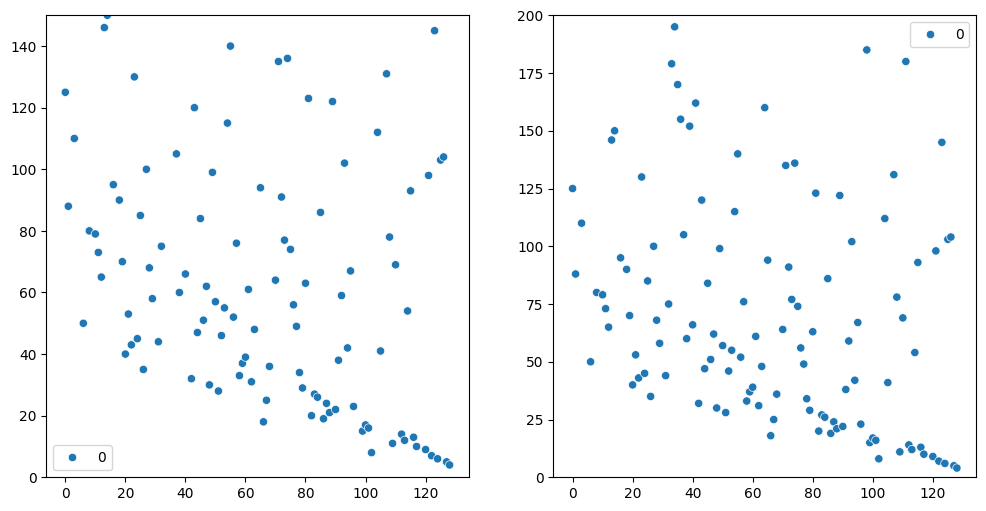

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.scatterplot([df["price"].unique()])
plt.ylim((0,150))
plt.subplot(1,2,2)
sns.scatterplot([df["price"].unique()])
plt.ylim((0,200))

In [8]:
# En X_train eliminaremos los outliers de precio por encima de 150

### Dividimos el dataset en train y test

In [9]:
df_train, df_test = train_test_split(df, 
                                     test_size=0.20,
                                     random_state=63)


#Eliminamos outliers de precio en train
df_train = df_train[df_train["price"]<=150]

# Definimos las variables de X_train e y_train de los datos de train
X_train = df_train.drop(columns=['title', 'designation', 'description', 'points'], axis=1)
y_train = df_train['points']

# También los de test
X_test = df_test.drop(columns=['title', 'designation', 'description', 'points'])
y_test = df_test['points']

In [10]:
X_train

,vintage,winery,style,variety,denominacion,price,aging_1,region
1742,2017,Matsu,Red wine,Tempranillo,Toro,15.0,No Aplica,Toro
183,2013,Torres,Red wine,Red Blends,Priorat,35.0,No Aplica,Priorat
343,2012,Bodegas Olarra,Red wine,Tempranillo Blend,Rioja,28.0,Reserva,Rioja
159,2013,Remírez de Ganuza,Red wine,Tempranillo Blend,Rioja,50.0,Reserva,Rioja
1371,2013,Beronia,Red wine,Tempranillo Blend,Rioja,17.0,Reserva,Rioja
...,...,...,...,...,...,...,...,...
2577,2016,Viñedos de Alfaro,Red wine,Tempranillo,Rioja,21.0,No Aplica,Rioja
288,2012,Eguren Ugarte,Red wine,Tempranillo Blend,Rioja,32.0,Reserva,Rioja
2386,2014,De Muller,Red wine,Red Blends,Priorat,20.0,No Aplica,Priorat
1239,2014,Rioja Vega,Red wine,Tempranillo Blend,Rioja,35.0,Reserva,Rioja


In [11]:
# Definimos la función con las métricas con las que evaluar los modelos y también el dataframe donde guardar los resultados
results_df = pd.DataFrame(columns=['Model', 'Partition', 'R^2', 'MAE', 'RMSE'])
def evaluate_model(model_name, y_true, y_pred, partition):
    r2 =     metrics.r2_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse =  metrics.root_mean_squared_error(y_true, y_pred)
    return {
        'Model': model_name,
        'Partition': partition,
        'R^2': r2,
        'MAE': mae,
        'RMSE': rmse
    }

Los modelos se han probado a través de archivos de python comparando entre aplicarles un selectKbest, un pca o un cluster y se han ido guardando cada uno en un archivo pickle dentro de la carpeta del modelo correspondiente en el subdirectorio models.
Ahora para comparar sus métricas y quedarnos con el mejor para llevarlo al streamlit, vamos a recorrernos la carpeta **/models** y vamos a ir evaluando cada archivo pickle que encuentre dentro las subcarpetas de los modelos.
El único modelo que no se va a incluir en esta tabla es la red neuronal realizada con keras, porque no se le puede aplicar la función de evaluación anterior.  

In [12]:
# Ruta de la carpeta raíz
root_folder = '../models'

# Iterar sobre las subcarpetas y archivos
for subdir, _, files in os.walk(root_folder):
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            
            # Cargar el archivo pickle
            with open(file_path, 'rb') as f:
                    model = pickle.load(f)
                    y_pred_train = model.predict(X_train)
                    y_pred_test = model.predict(X_test)
                    # Evaluar el modelo
                    results_train = evaluate_model(model, y_train, y_pred_train, "train")
                    results_train["Model"] = file_path
                    results_test = evaluate_model(model, y_test, y_pred_test, "test") 
                    results_test["Model"] = file_path                   
                    results_df = pd.concat([results_df, pd.DataFrame([results_train])], ignore_index=True)
                    results_df = pd.concat([results_df, pd.DataFrame([results_test])], ignore_index=True)



In [13]:
results_df

,Model,Partition,R^2,MAE,RMSE
0,../models\final_model.pkl,train,0.736253,1.269429,1.611857
1,../models\final_model.pkl,test,0.534864,1.708293,2.123929
2,../models\KNN\best_estimator_Clustering2.pkl,train,0.998356,0.013765,0.127257
3,../models\KNN\best_estimator_Clustering2.pkl,test,0.452375,1.804109,2.304580
4,../models\KNN\best_estimator_PCA3.pkl,train,0.998356,0.013765,0.127257
5,../models\KNN\best_estimator_PCA3.pkl,test,0.461320,1.803010,2.285680
6,../models\KNN\best_estimator_SelectKBest1.pkl,train,0.526311,1.688745,2.160127
7,../models\KNN\best_estimator_SelectKBest1.pkl,test,0.467800,1.789530,2.271893
8,../models\LightGBM\best_estimator_Clustering2.pkl,train,0.509128,1.734537,2.198958
9,../models\LightGBM\best_estimator_Clustering2.pkl,test,0.461967,1.796222,2.284309


In [14]:
# Guardamos los resultados en un archivo CSV para poder consultarlos en caso necesario
results_df.to_csv('evaluation_results.csv', index=False)


In [15]:
# Cargamos los resultados de Keras para ver si podríamos considerarlo como mejor modelo predictivo
keras_results = pd.read_csv("../src/Keras/results_Keras.csv")

In [16]:
keras_results

,Model,MAE,RMSE
0,Keras Sequential,9.216052,13.093421


Como podemos ver, el resultado de la red neuronal es el peor que hemos obtenido, por tanto no lo vamos a tener en cuenta para la decisión del mejor modelo de predicción

In [17]:
#volvemos a nuestra tabla de resultados del resto de modelos y la filtramos por los resultados obtenidos en test, ya que es en los que nos basaremos para tomar la decisión. Los ordenamos de menor a mayor MAE, porque lo que buscamos es el valor más cercano a 0
results_df[results_df["Partition"] == "test"].sort_values(by="MAE")

,Model,Partition,R^2,MAE,RMSE
1,../models\final_model.pkl,test,0.534864,1.708293,2.123929
25,../models\RandomForestRegressor\best_estimator...,test,0.534864,1.708293,2.123929
13,../models\LightGBM\best_estimator_SelectKBest1...,test,0.530087,1.709256,2.134809
43,../models\XGBRegressor\best_estimator_SelectKB...,test,0.513803,1.731102,2.171483
33,../models\SVR\best_estimator_Clustering2.pkl,test,0.474688,1.740755,2.257141
23,../models\RandomForestRegressor\best_estimator...,test,0.508037,1.747039,2.184321
37,../models\SVR\best_estimator_SelectKBest1.pkl,test,0.477697,1.754141,2.250667
11,../models\LightGBM\best_estimator_PCA3.pkl,test,0.504133,1.759130,2.192971
35,../models\SVR\best_estimator_PCA3.pkl,test,0.475660,1.759179,2.255052
21,../models\RandomForestRegressor\best_estimator...,test,0.490993,1.763292,2.221837


In [18]:
#guardamos la tabla en una nueva variable
results_test = results_df[results_df["Partition"] == "test"].sort_values(by="MAE")

In [19]:
# Creamos otra variable con el top 10 de modelos según su MAE y la graficamos
top10 = results_test[:10]

In [20]:
top10

,Model,Partition,R^2,MAE,RMSE
1,../models\final_model.pkl,test,0.534864,1.708293,2.123929
25,../models\RandomForestRegressor\best_estimator...,test,0.534864,1.708293,2.123929
13,../models\LightGBM\best_estimator_SelectKBest1...,test,0.530087,1.709256,2.134809
43,../models\XGBRegressor\best_estimator_SelectKB...,test,0.513803,1.731102,2.171483
33,../models\SVR\best_estimator_Clustering2.pkl,test,0.474688,1.740755,2.257141
23,../models\RandomForestRegressor\best_estimator...,test,0.508037,1.747039,2.184321
37,../models\SVR\best_estimator_SelectKBest1.pkl,test,0.477697,1.754141,2.250667
11,../models\LightGBM\best_estimator_PCA3.pkl,test,0.504133,1.759130,2.192971
35,../models\SVR\best_estimator_PCA3.pkl,test,0.475660,1.759179,2.255052
21,../models\RandomForestRegressor\best_estimator...,test,0.490993,1.763292,2.221837


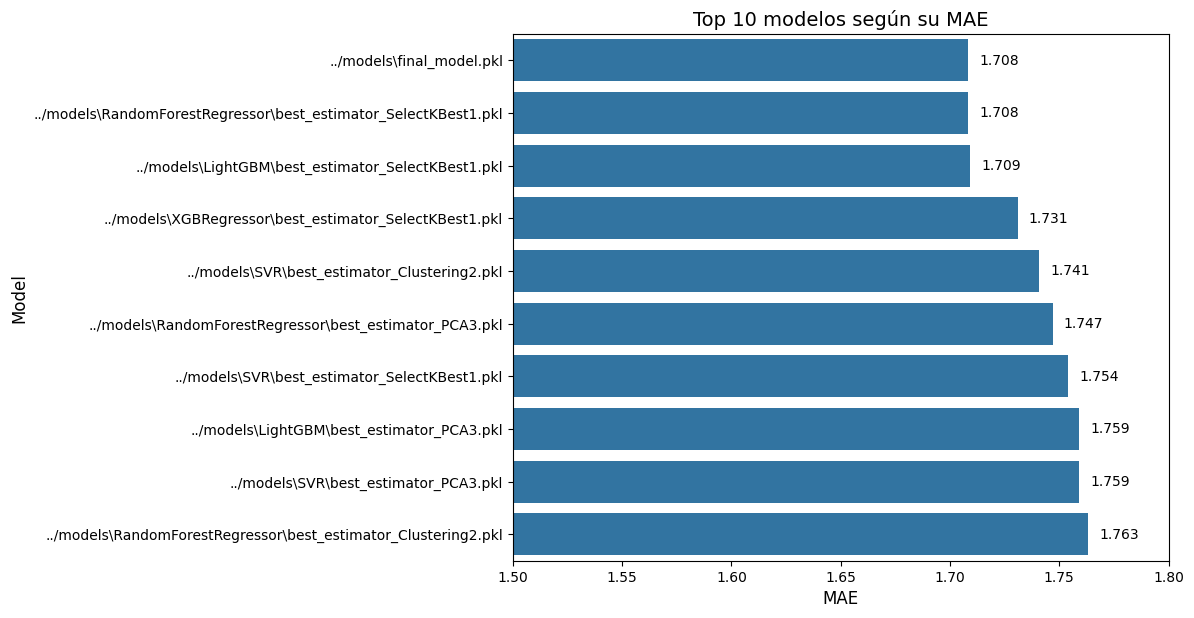

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(y=top10["Model"], x=top10["MAE"])  # Intercambia x e y
plt.xlim((1.5, 1.8))  # Cambia el límite al eje X
plt.tight_layout()
plt.title("Top 10 modelos según su MAE", fontsize=14)
plt.xlabel("MAE", fontsize=12)
plt.ylabel("Model", fontsize=12)
for index, value in enumerate(top10["MAE"]):
    plt.text(value + 0.005, index, f'{value:.3f}', ha='left', va='center', fontsize=10)




Como  podemos ver, el modelo RandomForestRegressor aplicándole un SelectKBest es el mejor modelo, por lo que es el que utilizaremos para desarrollar la aplicación de streamlit

In [327]:
top10["Model"].iloc[0]

'../models\\RandomForestRegressor\\best_estimator_SelectKBest1.pkl'

In [328]:
final_model = pickle.load(open(top10["Model"].iloc[0], 'rb'))

In [329]:
# lo guardamos directamente en la carpeta models como final_model
pickle.dump(final_model, open(f"../models/final_model.pkl", "wb"))

Comprobación características del modelo

In [330]:
final_model.feature_names_in_

array(['title', 'vintage', 'winery', 'style', 'variety', 'denominacion',
       'price', 'designation', 'aging_1', 'region', 'description'],
      dtype=object)

In [333]:
final_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('many_unique',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['winery', 'variety',
                                                   'denominacion']),
                                                 ('few_unique',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['style', 'aging_1']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'vintage'])])),
                ('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=np.int64(14),
                             score